In [1]:
import pandas as pd
import numpy as np
from math import ceil
import time
import glob,os
import matplotlib.pyplot as plt
import pickle
import pdb
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler


Using TensorFlow backend.


In [2]:
### Prepare data for LSTM: project: pedestrian trajecory prediction based on head orientation, previous trajectory and distance to cars

with open('/home/arash/ProjectVR/cleaneddata/ALLDATA', 'rb') as f:
    ALLDATA = pickle.load(f)
    
with open('/home/arash/ProjectVR/cleaneddata/experiments', 'rb') as f:
    experiments = pickle.load(f)
    
with open('/home/arash/ProjectVR/cleaneddata/DesignID', 'rb') as f:
    DesignID = pickle.load(f)

    

In [3]:
#removing error data
ALLDATAfortraj=ALLDATA.loc[-ALLDATA['starttime'].isin(['Err1','Err2','Err3','Err4','Err5'])]

#only observable columns by AV are selected
ALLDATAfortraj=ALLDATAfortraj[['File','Scenario','Speed Limit', 'Lane Width', 
                               'Mean Arrival Rate', 'Snowy','One way', 'two way',
                               'Two way with median', 'Night','starttime']] 


ALLDATAfortraj=pd.get_dummies(data=ALLDATAfortraj,columns=['Speed Limit', 'Lane Width', 
                               'Mean Arrival Rate'])

In [4]:
# limit trajectory records to a time frame starting from 1 sec before cross to the end.
trajectory=[]
for n in range(len(experiments)):    
    if len(ALLDATAfortraj[ALLDATAfortraj['File']==experiments[n]['filename'][0]]['starttime'])>0:
        df=experiments[n][experiments[n]['timeelaspsed'].astype(float)>
                          (float(ALLDATAfortraj[ALLDATAfortraj['File']==
                                                experiments[n]['filename'][0]]['starttime'])-1)]
        df=df.drop(columns=['timehr','timemin','timesec',])
        trajectory.append(df)

In [5]:
# build time series data from pedestrian movements
userXtraj=[]
usero1traj=[]
usero2traj=[]
usero3traj=[]
userdisttraj=[]
useraux=[]

for i in range(len(trajectory)):
    if len(trajectory[i][(trajectory[i]['status']=='u ') & (trajectory[i]['x'].astype(float)>650)])>0:
        oneroad=int(DesignID[DesignID['Card ID']==       #to see if the scenario is one road
                             int(ALLDATAfortraj[ALLDATAfortraj['File']
                                                ==trajectory[i].iloc[0,-1]]['Scenario'])]['Road Type_One way'])
        xarr=trajectory[i][(trajectory[i]['status']=='u ') & 
                           (trajectory[i]['x'].astype(float)>650)]['x'].values.astype(float)    
        # 650 threshold is the approximate x coordinate for the middle of the road, 
        #user trajectory in the end of experiment are removed
        
        
        #head orientation coordinates:
        headarr1=trajectory[i][(trajectory[i]['status']=='u ') & 
                           (trajectory[i]['x'].astype(float)>650)]['o1'].values.astype(float)  
        headarr2=trajectory[i][(trajectory[i]['status']=='u ') & 
                           (trajectory[i]['x'].astype(float)>650)]['o2'].values.astype(float)
        headarr3=trajectory[i][(trajectory[i]['status']=='u ') & 
                           (trajectory[i]['x'].astype(float)>650)]['o3'].values.astype(float)    
        
        
        
        aux= ALLDATAfortraj[ALLDATAfortraj['File'] == trajectory[i].iloc[0,-1]][   #get aux info 
                ['Snowy','Night', 'One way', 'two way', 'Two way with median',
                 'Speed Limit_30.0', 'Speed Limit_40.0', 'Speed Limit_50.0',
                 'Lane Width_2.5', 'Lane Width_2.75', 'Lane Width_3.0',
                 'Mean Arrival Rate_530.0', 'Mean Arrival Rate_750.0',
                 'Mean Arrival Rate_1100.0']].values
        aux=aux.reshape(aux.shape[1],)          #reshape to (14,)  14: number of aux categories
        aux =aux.astype(float) 

        
        
        firstpedindex=trajectory[i][(trajectory[i]['status']=='u ') & 
                           (trajectory[i]['x'].astype(float)>650)].index[0]  
                            #index for pedestrian 1st appearance
        pedindex=trajectory[i][(trajectory[i]['status']=='u ') & 
                           (trajectory[i]['x'].astype(float)>650)].index-firstpedindex   
                            #convert index to new format
        dist=[]
        for index, item in enumerate(pedindex):      #distance at every moment
            if index>0:
                bwped=trajectory[i].iloc[pedindex[index-1]:
                                         pedindex[index],:]  #data from one pedestrian idex to next
                if len(bwped[bwped['status'].str.contains('L',na=False)].index)==0:   
                    #if no cars on left lane at the moment
                    distance=100
                else:            
                    if oneroad==0:
                        if len((bwped[(bwped['x'].astype(float)>650) & (bwped['status'] !='u ') &
                                      (bwped['y'].astype(float)> bwped.iloc[0,1])]['y']))==0:     
                            #check if any car that has not passed exists  
                            #1st cond: car on left lane, 2nd: not a user data, 3rd: car has not passed ped yet
                            #only 3rd differs for oneway and two-way roads
                            distance=100
                        else:
                            distance=min(bwped[(bwped['x'].astype(float)>650) & (bwped['status'] !='u ') &
                                               (bwped['y'].astype(float)> bwped.iloc[0,1])]['y']) - bwped.iloc[0,1] 
                    else:   #one-way roads
                        if len((bwped[(bwped['x'].astype(float)>650) & (bwped['status'] !='u ') &
                                      (bwped['y'].astype(float)< bwped.iloc[0,1])]['y']))==0:     
                            #check if any car that has not passed exists  
                            #1st cond: car in left lane, 2nd not a user data, 3rd: car has not passed ped yet
                            #differs for oneway and two-way roads
                            distance = 100
                        else:
                            distance = bwped.iloc[0,1] - max(bwped[(bwped['x'].astype(float)>650)
                                      & (bwped['status'] !='u ') & (bwped['y'].astype(float)< 
                                                                    bwped.iloc[0,1])]['y']) 
                dist.append(distance)


        userXtraj.append(xarr)
        usero1traj.append(headarr1)
        usero2traj.append(headarr2)
        usero3traj.append(headarr3)
        userdisttraj.append(dist)
        useraux.append(aux)

###### Convert sequential tractory files to readable format for lstm. 

In [6]:
def sampleinput(userXtraj,usero1traj,usero2traj,usero3traj,userdisttraj, inputportion):
    X, o1, o2, o3, dist, y = list(), list(),list(), list(),list(), list()
    for i in range(len(userXtraj)):
        # find the end of this pattern
        xdistancecovered=max(userXtraj[i])-min(userXtraj[i])     #total distance covered by user from start to end of the expmeriment
        xinput=xdistancecovered*inputportion                    #distance that is used as input to the model                   
        breakpoint=min(userXtraj[i])+xinput
        n_steps=len([x for x in userXtraj[i] if x<breakpoint])
        
        # gather input and output parts of the pattern
        seq_x, seq_y = userXtraj[i][0:n_steps], userXtraj[i][n_steps:]
        seq_o1=usero1traj[i][0:n_steps]
        seq_o2=usero2traj[i][0:n_steps]
        seq_o3=usero3traj[i][0:n_steps]
        seq_dist=userdisttraj[i][0:n_steps]

        X.append(seq_x)
        o1.append(seq_o1)
        o2.append(seq_o2)
        o3.append(seq_o3)
        dist.append(seq_dist)
        y.append(seq_y)
        
    return X,o1,o2,o3 ,dist, y

inputportion = 0.3

# convert into input/output

In [7]:
X, o1, o2, o3, dist, y = sampleinput(userXtraj,usero1traj, usero2traj, usero3traj,userdisttraj, inputportion)

In [8]:
#check for ouliers
dur=[]
for i in range(len(X)):
    x=X[i].shape[0]+y[i].shape[0]
    dur.append(x)

dur=pd.DataFrame(dur,columns=['duration'])

dur.describe()

,duration
count,3418.000000
mean,45.064073
std,52.482100
min,1.000000
25%,25.000000
50%,31.000000
75%,42.000000
max,929.000000


(array([2.777e+03, 3.780e+02, 1.350e+02, 5.700e+01, 2.400e+01, 2.000e+01,
        7.000e+00, 3.000e+00, 7.000e+00, 2.000e+00, 2.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 2.000e+00]),
 array([  1. ,  47.4,  93.8, 140.2, 186.6, 233. , 279.4, 325.8, 372.2,
        418.6, 465. , 511.4, 557.8, 604.2, 650.6, 697. , 743.4, 789.8,
        836.2, 882.6, 929. ]),
 <a list of 20 Patch objects>)

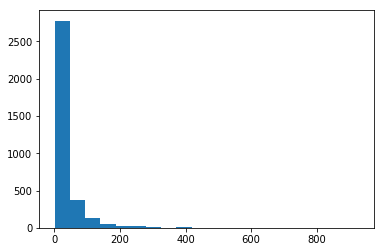

In [9]:
plt.hist(dur.iloc[:,0],bins=20)

In [10]:
#indices of experiments when it takes more than ~15 seconds  to cross. 109 rows out of total 3424 removed
out=dur[dur['duration']>150].index

for i in sorted(out,reverse=True):      #reverse is true to make sure indices does not change after removing
    del X[i]
    del o1[i]
    del o2[i]
    del o3[i]
    del dist[i]
    del y[i]
    del useraux[i]

In [12]:
#remove items where no data is kept for either X for y, due to pedestrian not moving at all
for i in reversed(range(len(X))):           
    if (len(X[i])==0) or (len(y[i])==0):
        del X[i]
        del o1[i]
        del o2[i]
        del o3[i]
        del dist[i]
        del y[i]
        del useraux[i]

In [13]:
# converting list to array:
X=np.array(X)
o1=np.array(o1)
o2=np.array(o2)
o3=np.array(o3)
dist=np.array(dist)
y=np.array(y)
useraux=np.array(useraux)

In [14]:
allseqdata=[X,o1,o2,o3,dist,y]     #save all the sequence data to file

In [15]:
# save to pickle
with open('/home/arash/ProjectVR/cleaneddata/seqdata', 'wb') as f:
    pickle.dump(allseqdata, f)
    

In [16]:
with open('/home/arash/ProjectVR/cleaneddata/auxdata', 'wb') as f:
    pickle.dump(useraux, f)